<img src=docs/tudelft_logo.jpg width=50%>

## Data-driven Design and Analyses of Structures and Materials (3dasm)

## Lecture 10

### Miguel A. Bessa | <a href = "mailto: M.A.Bessa@tudelft.nl">M.A.Bessa@tudelft.nl</a>  | Associate Professor

**What:** A lecture of the "3dasm" course

**Where:** This notebook comes from this [repository](https://github.com/bessagroup/3dasm_course)

**Reference for entire course:** Murphy, Kevin P. *Probabilistic machine learning: an introduction*. MIT press, 2022. Available online [here](https://probml.github.io/pml-book/book1.html)

**How:** We try to follow Murphy's book closely, but the sequence of Chapters and Sections is different. The intention is to use notebooks as an introduction to the topic and Murphy's book as a resource.
* If working offline: Go through this notebook and read the book.
* If attending class in person: listen to me (!) but also go through the notebook in your laptop at the same time. Read the book.
* If attending lectures remotely: listen to me (!) via Zoom and (ideally) use two screens where you have the notebook open in 1 screen and you see the lectures on the other. Read the book.

**Optional reference (the "bible" by the "bishop"... pun intended 😆) :** Bishop, Christopher M. *Pattern recognition and machine learning*. Springer Verlag, 2006.

**References/resources to create this notebook:**
* This simple tutorial is still based on a script I created for this article: https://imechanica.org/node/23957
* It follows from some examples provided by the scikit-learn user guide, which seem to have originated from Mathieu Blondel, Jake Vanderplas, Vincent Dubourg, and Jan Hendrik Metzen.

Apologies in advance if I missed some reference used in this notebook. Please contact me if that is the case, and I will gladly include it here.

## **OPTION 1**. Run this notebook **locally in your computer**:
1. Confirm that you have the 3dasm conda environment (see Lecture 1).

2. Go to the 3dasm_course folder in your computer and pull the last updates of the [repository](https://github.com/bessagroup/3dasm_course):
```
git pull
```
3. Open command window and load jupyter notebook (it will open in your internet browser):
```
conda activate 3dasm
jupyter notebook
```
4. Open notebook of this Lecture.

## **OPTION 2**. Use **Google's Colab** (no installation required, but times out if idle):

1. go to https://colab.research.google.com
2. login
3. File > Open notebook
4. click on Github (no need to login or authorize anything)
5. paste the git link: https://github.com/bessagroup/3dasm_course
6. click search and then click on the notebook for this Lecture.

In [1]:
# Basic plotting tools needed in Python.

import matplotlib.pyplot as plt # import plotting tools to create figures
import numpy as np # import numpy to handle a lot of things!
from IPython.display import display, Math # to print with Latex math

%config InlineBackend.figure_format = "retina" # render higher resolution images in the notebook
plt.style.use("seaborn") # style for plotting that comes from seaborn
plt.rcParams["figure.figsize"] = (8,4) # rescale figure size appropriately for slides

## Outline for today

* Introduction tutorial on Gaussian Processes (no theory today!)
    - Using Scikit-learn for Gaussian Process Regression (noiseless and noisy datasets)
* Introduction tutorial on Artificial Neural Networks (no theory today!)
    - Using Keras for regression with Artificial Neural Networks (noiseless and noisy datasets)

**Reading material**: This notebook + (GPs in Section 17.3 of book; ANNs in Chapter 13)

## Today's lecture is going to be more practical

Similarly to the previous lecture, we will focus on the practical aspects of two new ML models **without deriving them yet**.

The goal is for you to be able to use these models as *black boxes* and for you to explore them in the Midterm Project assignment (reverse engineering them!).

* So, today we will focus on how to train:
    - **Gaussin Processes** using [scikit-learn](https://scikit-learn.org)
    - **Artificial Neural Networks** (ANNs) using [keras](https://keras.io/) and [tensorflow](https://www.tensorflow.org/)

This way, you can explore these models in the Midterm Project, while in later lectures we will derive these and other models that we use in this course.

## 1. Short tutorial on 1D regression with Gaussian Processes

### Recall the model for linear regression with polynomial basis functions (Lecture 9)

1. Observation distribution:

$$
p(y|x, \mathbf{z}) = \mathcal{N}(y| \mu_{y|z} = f(x;\, \mathbf{z}), \sigma_{y|z}^2 = \sigma^2)
$$

where $f(x;\, \mathbf{z}) = \mathbf{w}^T \boldsymbol{\phi}(x)$ and each term is defined by:

* $\mathbf{z} = (\mathbf{w}, \sigma)$ are all the hidden rv's of the model, i.e. the model parameters.
    * the vector $\mathbf{w} = [w_0, w_1, w_2 ..., w_d]^T$ includes the **bias** term $w_0$ and the remaining **weights** $w_i$ with $i=1,..., d$.
    * the vector $\boldsymbol{\phi}(x) = [1, x, x^2, ..., x^d]^T$ includes the **basis functions**, which now correspond to a polynomial of degree $d$.

2. A chosen Prior distribution for each hidden rv of $\mathbf{z}$.

As we will see, Gaussian Processes generalize this model by introducing nonlinear functions and by correlating the entire dataset in a very interesting way.

For now, we will just share how GPs make regression predictions for one-dimensional functions (input $x$ and output $y$). We will follow Görtler et al. (2019) but with a different notation: https://distill.pub/2019/visual-exploration-gaussian-processes

* In Gaussian Processes **each** OUTPUT value $y_i$ in the training data is treated as a random variable that follows a Gaussian distribution:

$\mathbf{y} = \begin{bmatrix}y_1\\ y_2 \\ \vdots\\ y_n \end{bmatrix} \sim \mathcal{N}(\boldsymbol{\mu} , \boldsymbol{\Sigma})$

and where the joint distribution of all the output values $\mathbf{y}$ is also Gaussian (a multivariate Gaussian) defined by a mean vector $\boldsymbol{\mu}$ and a covariance matrix $\boldsymbol{\Sigma}$. The mean is usually assumed to be zero.

We will do the derivations later, but for now we just want to know that the expression for the covariance matrix depends on a nonlinear function called the "covariance function" or "kernel" $k$ that is calculated for **each** pair of INPUT points $x_i$ and $x_j$:

$\Sigma_{ij} = \text{Cov}(y_i,y_j) = k(x_i,x_j)+\alpha_i^2 \delta_{ij}  \quad \Rightarrow \quad \boldsymbol{\Sigma} = \mathbf{K} + \mathbf{R} $

where the kernel $k(x_i,x_j)$ can be many different kinds of functions (with some special properties) and $\alpha_i^2$ is the noise level of $y_i$.


* An example of a kernel function is the RBF: $k(x_i,x_j) = {\color{red}\eta}^2\exp{\left(-\frac{||x_i-x_j||^2}{2{\color{red}\lambda}^2}\right)}$


* Every kernel function has a set of unknown parameters (in red). The RBF has 2 parameters. You can visualize different kernel functions in this figure: https://distill.pub/2019/visual-exploration-gaussian-processes/#MultipleKernels

In the Gaussian Process method, we start by **choosing** a kernel function with an **initial guess** for the values of the parameters. This defines our **prior** information in conjunction with the assumption that the variables follow a multivariate Gaussian distribution:

$\begin{bmatrix}\mathbf{y}\\ y^* \end{bmatrix} \sim \mathcal{N}\left(\mathbf{0} , \, \begin{bmatrix}\mathbf{K}+\mathbf{R} & \mathbf{k}_*\\ \mathbf{k}_*^T & k(x^*,x^* \end{bmatrix}\right)$


As we saw before in the course, Multivariate Gaussian distributions have very interesting properties and it turns out that based on the above assumptions a Gaussian Process predicts both the **mean** and the **variance** of the output point $y^*$ by the following matrix operations:

$\mathbb{E}[y^*]=\mathbf{k}_*^T\left(\mathbf{K}+\mathbf{R}\right)^{-1}\mathbf{y}$

$\text{Cov}[y^*]=k(x^*,x^*)-\mathbf{k}_*^T\left(\mathbf{K}+\mathbf{R}\right)^{-1}\mathbf{k}_*$

* The <span style="color:red">**key concept**</span> is that the prediction of the mean and variance of the new point $y^*$ depends on the values of the parameters of the kernel function (which are **UNKNOWN**).


* However, despite the fact that we don't know the parameters of the kernel function, they can be obtained by **Bayesian inference**.

As we saw previousy, Bayesian inference is possible by using Bayes rule to find the **posterior** information. This involves doing Marginalization and Conditioning. We will do this in the next lectures.

Today, we are focusing on learning how to do Gaussian Process regression for one-dimensional datasets.

Let's start with a noiseless case.

In [2]:
from sklearn.model_selection import train_test_split

# Function to "learn"
def f(x):
    return x * np.sin(x)

n_data = 50 # number of points in our dataset
testset_ratio = 0.90 # ratio of test set points from the dataset
x_data = np.linspace(0, 10, n_data) # uniformly spaced points
y_data = f(x_data) # function values at x_data

X_data = np.reshape(x_data,(-1,1)) # a 2D array that scikit-learn likes

seed = 1987 # set a random seed so that everyone gets the same result
np.random.seed(seed)

# Let's split into 10% training points and the rest for testing:
X_train, X_test, y_train, y_test = train_test_split(X_data,
                                    y_data, test_size=testset_ratio,
                                    random_state=seed)

x_train = X_train.ravel() # just for plotting later
x_test = X_test.ravel() # just for plotting later

print("Here's a print of X_train:\n", X_train)

Here's a print of X_train:
 [[6.12244898]
 [8.57142857]
 [7.14285714]
 [2.85714286]
 [8.97959184]]


### Gaussian Process Regression (GPR) for noiseless datasets

Let's use the RBF kernel for our predictions:

$$
k(x_i,x_j) = {\color{red}\eta}^2\exp{\left(-\frac{||x_i-x_j||^2}{2{\color{red}\lambda}^2}\right)}
$$

with an initial guess for the parameters as: $\eta = 1$ and $\lambda = 10$.

In [3]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, ExpSineSquared, ConstantKernel

# Define the kernel function
kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2)) # This is the standard RBF kernel
#kernel = 1.0 * RBF(10, (1e-2, 1e2)) # Same kernel as above (scikit-learn assumes constant variance if you just
                                     # write RBF without the constant kernel or without multiplying by 1.0)

# Other examples of kernels:
#kernel = ExpSineSquared(length_scale=3.0, periodicity=3.14,
#                       length_scale_bounds=(0.1, 10.0),
#                       periodicity_bounds=(0.1, 10)) * RBF(3.0, (1e-2, 1e2))
#kernel = Matern(length_scale=1.0, length_scale_bounds=(1e-2, 1e2),nu=1.5)
                
gp_model = GaussianProcessRegressor(kernel=kernel, alpha=1e-10, n_restarts_optimizer=20) # using a small alpha

# Fit to data to determine parameters
gp_model.fit(X_train, y_train)

# Make the prediction on the entire dataset (for plotting)
y_data_pred, sigma_data = gp_model.predict(X_data, return_std=True) # also output the uncertainty (std)

# Predict for test set (for error metric)
y_pred, sigma = gp_model.predict(X_test, return_std=True) # also output the uncertainty (std)

In [4]:
# Plot the function, the prediction and the 95% confidence interval
fig1, ax1 = plt.subplots()

ax1.plot(x_data, y_data, 'r:', label=u'ground truth: $f(x) = x\,\sin(x)$') # function to learn

ax1.plot(x_data, y_data_pred, 'b-', label="GPR prediction")
ax1.fill(np.concatenate([x_data, x_data[::-1]]),
         np.concatenate([y_data_pred - 1.9600 * sigma_data,
                        (y_data_pred + 1.9600 * sigma_data)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')

ax1.plot(x_train, y_train, 'ro', markersize=6, label="training points") # noiseless data
ax1.plot(x_test, y_test, 'kX', markersize=6, label="testing points") # Plot test points

ax1.set_xlabel('$x$', fontsize=20)
ax1.set_ylabel('$f(x)$', fontsize=20)
ax1.set_title("Posterior kernel: %s"
              % gp_model.kernel_, fontsize=20) # Show in the title the value of the hyperparameters
ax1.set_ylim(-10, 15) # just to provide more space for the legend
ax1.legend(loc='upper left', fontsize=15)
fig1.set_size_inches(8,8)
plt.close(fig1) # close the plot to see it in next cell

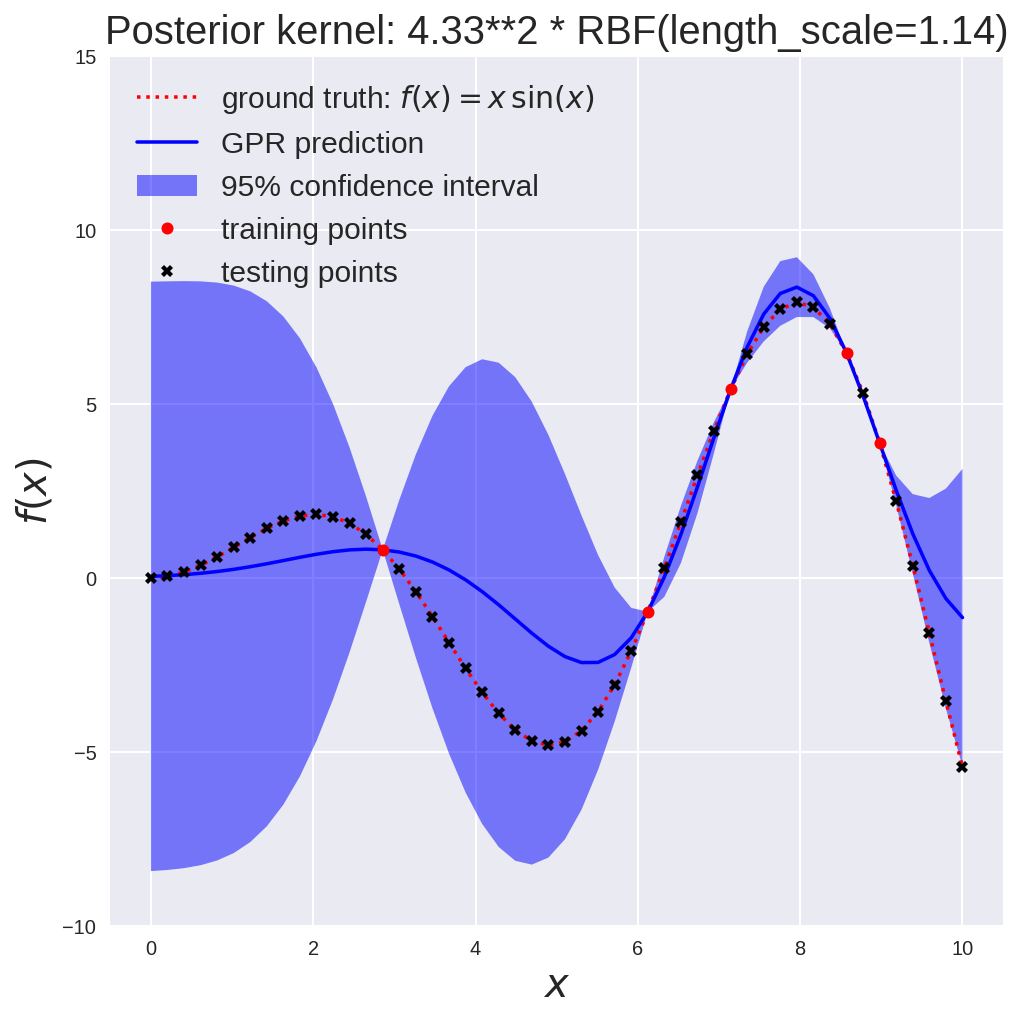

In [5]:
fig1 # plot figure.

### Exercise 1

Fit a polynomial of degree 4 (like we did last class) and compute the error metrics for that model as well as the above mentioned Gaussian process.

In [6]:
# Write your code for Exercise 1:

# until here.

Gaussian Process Regression approximates the function much better...

* However, note that the **choice of kernel** used in GPR affects the quality of the prediction.

### Gaussian Process regression for noisy datasets

Let's recreate the noisy dataset from $f(x)=x\sin{x}$, as we did in Lecture 9:

In [7]:
# Now let's also create the noisy dataset:
random_std = 0.5 + 1.0 * np.random.random(y_data.shape) # np.random.random returns random number between [0.0, 1.0)
noise = np.random.normal(0, random_std) # sample vector from Gaussians with random standard deviation
y_noisy_data = y_data + noise # Perturb every y_data point with Gaussian noise

# Pair up points with their associated noise level (because of train_test_split):
Y_noisy_data = np.column_stack((y_noisy_data,noise))

# Split into 10% training points and the rest for testing:
X_train, X_test, Y_noisy_train, Y_noisy_test = train_test_split(X_data,
                                    Y_noisy_data, test_size=testset_ratio,
                                    random_state=seed) # "noisy_train" is a great name for a variable, hein?
# NOTE: since we are using the same seed and we do train_test_split on the same X_data and y_noisy_data is
#       just y_data + noise, we are splitting the dataset exactly in the same way! This is nice because we
#       want to keep the comparison as fair as possible.

# Finally, for plotting purposes, let's convert the 2D arrays into 1D arrays (vectors):
x_train = X_train.ravel()
x_test = X_test.ravel()
y_noisy_train = Y_noisy_train[:,0]
noise_train = Y_noisy_train[:,1]
y_noisy_test = Y_noisy_test[:,0]
noise_test = Y_noisy_test[:,1]

print("Note that X_train and X_test are the same data that we used for the noiseless case.")
print("Here's a print of X_train:\n", X_train)

Note that X_train and X_test are the same data that we used for the noiseless case.
Here's a print of X_train:
 [[6.12244898]
 [8.57142857]
 [7.14285714]
 [2.85714286]
 [8.97959184]]


In [8]:
# Instanciate a Gaussian Process model
kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))

# Fitting for noisy data, if we have access to the uncertainty at the training points (usually we don't!), then
# we can include the noise level at the alpha parameter
gp_model = GaussianProcessRegressor(kernel=kernel, alpha=noise_train**2, n_restarts_optimizer=5)

# Fit to data to determine the parameters of the model
gp_model.fit(X_train, y_noisy_train)

# Make the predictions
y_noisy_pred, sigma_noisy = gp_model.predict(X_test, return_std=True) # predictions including uncertainty (std)
y_noisy_data_pred, sigma_noisy_data = gp_model.predict(X_data, return_std=True) # for plotting

# Plot the function, the prediction and the 95% confidence interval
fig1, ax1 = plt.subplots() # This opens a new figure

ax1.plot(x_data, f(x_data), 'r:', label=u'ground truth: $f(x) = x\,\sin(x)$') # function to learn
ax1.errorbar(x_train, y_noisy_train, noise_train, fmt='ro', markersize=6, label=u'training points inc. uncertainty')
ax1.errorbar(x_test, y_noisy_test, noise_test, fmt='kX', markersize=6, label=u'testing points inc. uncertainty')

ax1.plot(x_data, y_noisy_data_pred, 'b-', label="GPR prediction")
ax1.fill(np.concatenate([x_data, x_data[::-1]]),
         np.concatenate([y_noisy_data_pred - 1.9600 * sigma_noisy_data,
                        (y_noisy_data_pred + 1.9600 * sigma_noisy_data)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
ax1.set_xlabel('$x$', fontsize=20)
ax1.set_ylabel('$f(x)$', fontsize=20)
ax1.set_ylim(-10, 15) # just to provide more space for the legend
ax1.legend(loc='upper left', fontsize=15)
fig1.set_size_inches(8,8)
plt.close(fig1)

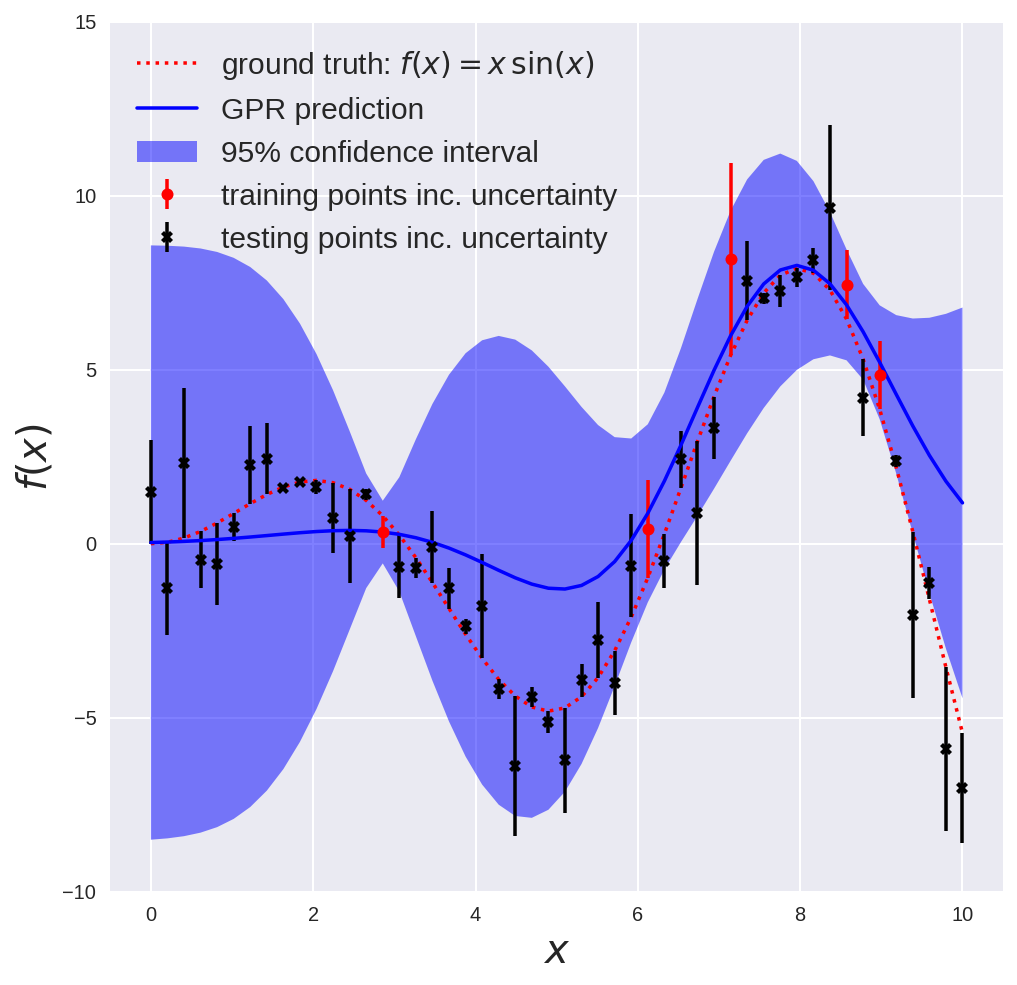

In [9]:
fig1 # plot figure.

### Exercise 2

Fit a polynomial of degree 4 (like we did last class) and compute the error metrics for that model as well as the above mentioned Gaussian process.

In [10]:
# Exercise 2.

# until here.

Well done...

In the Midterm Project you will empirically explore Gaussian Processes.

## 2. Short tutorial on 1D regression with Artificial Neural Networks

ANNs for regression are not that different when compared to linear regression.

Consider again the observation distribution as we wrote it in the beginning of the lecture.

$$
p(y|x, \mathbf{z}) = \mathcal{N}(y| \mu_{y|z} = f(x;\, \mathbf{z}), \sigma_{y|z}^2 = \sigma^2)
$$

But now, instead of modeling the mean of the distribution using polynomial basis functions by $f(x;\, \mathbf{z}) = \mathbf{w}^T \boldsymbol{\phi}(x)$, consider a simple extension where the **basis functions also have their own parameters**:

$$
f(x;\, \mathbf{z}) = \mathbf{w}^T \boldsymbol{\phi}(x;\, \mathbf{z}_2)
$$

where $\mathbf{z} = (\mathbf{z}_1,\, \mathbf{z}_2)$ and $\mathbf{z}_1 = (\mathbf{W},\, \mathbf{b})$ are all the parameters of the model.

Instead of stopping here,

$$
f(x;\, \mathbf{z}) = \mathbf{w}^T \boldsymbol{\phi}(x;\, \mathbf{z}_2)
$$

we can also repeat this recursively $L$ times to create more complex transformations:

$$
f(x;\, \mathbf{z}) = f_L\left( f_{L-1}\left(\cdots \left(f_1\left(x\right)\right)\cdots\right)\right)
$$

where $f_l(x) = f(x;\, \mathbf{z}_l)$ is the function at layer $l$ of our recursive transformation.

This is the key idea behind **deep neural networks**.

* Confused?

Let's try to see this for a very simple case. Consider again the observation distribution:

$$
p(y|x, \mathbf{z}) = \mathcal{N}(y| \mu_{y|z} = f(x;\, \mathbf{z}), \sigma_{y|z}^2 = \sigma^2)
$$

The simplest extension comes from using a nonlinear function $f_1$ acting on our well-known linear model:

$$
\mu_{y|z} = f(x;\, \mathbf{z}) = f_1\left( \mathbf{w}^T \boldsymbol{\phi}(x) \right) = f_1\left( f_0 \left(x; \mathbf{z}_0 \right) \right) = f_1\left(b_0 + w_0 x\right)
$$

where we are calling our linear regression model as $f_0 \left(x; \mathbf{z}_0 \right)$.

So, our model for the mean of the observation distribution becomes:

$$
\mu_{y|z} = f_1\left( b_0 + w_0 x \right)
$$

But why stop here?

Why not introducing more parameters?

$$
\mu_{y|z} = b_1 + w_1 f_1\left( b_0 + w_0 x \right)
$$

But why stop here?

What if we apply another nonlinear function $f_2$?

$$
\mu_{y|z} = f_2\left(b_1 + w_1 f_1\left( b_0 + w_0 x \right)\right)
$$

What about doing this recursively $L$ times to create more complex transformations?

$$
f(x;\, \mathbf{z}) = f_L\left( f_{L-1}\left(\cdots \left(f_1\left(b_0 + w_0 x\right)\right)\cdots\right)\right)
$$

This is one of the simplest examples of an Artificial Neural Network architecture called feedforward architecture.

We will look into this model carefully in a few lectures.

For now, I just want to draw a schematic so that you understand the number of parameters that starts appearing!

* Draw on the board a feedforward ANN with 2 hidden layers for 1D case.
    * First hidden layer with 3 neurons and second hidden layer with 2 neurons.

Two examples of these nonlinear functions.


<div>
<img style="float: left"; src=docs/nonlin_fn.png width=500px></div>

Let's now focus on how to create an ANN model for 1D regression using:
1. A feedforward architecture with 2 dense hidden layers
2. The ReLu activation function
3. Adam optimizer

In [11]:
# Let's create a function defining our Artificial Neural Network.
from tensorflow import keras # fast library for ANNs
from tensorflow.keras.optimizers import Adam # import the optimizer you want to use to calculate the parameters
from keras.models import Sequential # to create a feedforward neural network
from keras.layers.core import Dense # to create a feedforward neural network with dense layers
#
# Function to create the ANN model (in this case we are creating )
def create_ANN(input_dimensions=1, # number of input variables
               neurons1=3, # number of neurons in first hidden layer
               neurons2=2, # number of neurons in second hidden layer
               activation='relu', # activation function
               optimizer='adam'): # optimization algorithm to compute the weights and biases
    # create model
    model = Sequential() # Feedforward architecture
    model.add(Dense(neurons1, input_dim=input_dimensions, activation=activation)) # first hidden layer
    model.add(Dense(neurons2, activation=activation)) # second hidden layer
    model.add(Dense(1)) # output layer with just one neuron because we have only one output (1D problem!)
    model.compile(loss='mse', # error metric to measure our NLL (loss)
                  optimizer=optimizer)
    return model

In addition, let's introduce something important: dataset preprocessing.

Standardizing our dataset is good practice and can be important for many ML algorithms (ANNs included).

In [12]:
# Standardizing your dataset is good practice and can be important for ANNs!
from sklearn.preprocessing import StandardScaler # standardize the dataset with scikit-learn
#
scaler = StandardScaler().fit(X_train) # Check scikit-learn to see what this does!
#
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)
X_data_scaled=scaler.transform(X_data)
#

In [13]:
from keras.wrappers.scikit_learn import KerasRegressor # a new version will use scikeras
# Now create your first ANN model!
neurons1=200 # number of neurons for the first hidden layer
neurons2=10 # number of neurons for the second hidden layer
batch_size = len(X_train) # considering the entire dataset for updating the weights and biases in each epoch
optimizer = Adam(learning_rate=0.001) # specifying the learning rate value for the optimizer (PLAY WITH THIS!)
ANN_model = KerasRegressor(build_fn=create_ANN, neurons1=neurons1, neurons2=neurons2,
                           batch_size=batch_size, epochs=150, optimizer=optimizer,
                           validation_data=(scaler.transform(X_test), y_test))

/tmp/ipykernel_12147/1298898400.py:7: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  ANN_model = KerasRegressor(build_fn=create_ANN, neurons1=neurons1, neurons2=neurons2,


In [14]:
# Now that we created our first ANN model, let's fit it to our (scaled) dataset!
history = ANN_model.fit(X_train_scaled, y_train)

2022-03-19 19:40:45.012623: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-19 19:40:45.122952: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-19 19:40:45.123476: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-19 19:40:45.123895: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1900] Ignoring visible gpu device (device: 0, name: GeForce GTX 560M, pci bus id: 0000:01:00.0, compute capability: 2.1) with Cuda compute capability 2.1. The minimum required Cuda capability is 3.5.
2022-03-19 19:40:45.125169: I tensorflow/core/platform/cpu_fe

Epoch 1/150
1/1 [==============================] - 1s 523ms/step - loss: 17.6255 - val_loss: 13.9907
Epoch 2/150
1/1 [==============================] - 0s 28ms/step - loss: 17.5265 - val_loss: 13.9696
Epoch 3/150
1/1 [==============================] - 0s 29ms/step - loss: 17.4302 - val_loss: 13.9507
Epoch 4/150
1/1 [==============================] - 0s 27ms/step - loss: 17.3398 - val_loss: 13.9466
Epoch 5/150
1/1 [==============================] - 0s 35ms/step - loss: 17.2645 - val_loss: 13.9364
Epoch 6/150
1/1 [==============================] - 0s 25ms/step - loss: 17.2087 - val_loss: 13.9252
Epoch 7/150
1/1 [==============================] - 0s 34ms/step - loss: 17.1523 - val_loss: 13.9137
Epoch 8/150
1/1 [==============================] - 0s 29ms/step - loss: 17.0954 - val_loss: 13.9019
Epoch 9/150
1/1 [==============================] - 0s 29ms/step - loss: 17.0382 - val_loss: 13.8896
Epoch 10/150
1/1 [==============================] - 0s 25ms/step - loss: 16.9803 - val_loss: 13.877

1/1 [==============================] - 0s 29ms/step - loss: 7.4422 - val_loss: 12.6115
Epoch 83/150
1/1 [==============================] - 0s 35ms/step - loss: 7.2578 - val_loss: 12.6104
Epoch 84/150
1/1 [==============================] - 0s 28ms/step - loss: 7.0748 - val_loss: 12.6103
Epoch 85/150
1/1 [==============================] - 0s 35ms/step - loss: 6.8930 - val_loss: 12.6112
Epoch 86/150
1/1 [==============================] - 0s 36ms/step - loss: 6.7130 - val_loss: 12.6132
Epoch 87/150
1/1 [==============================] - 0s 36ms/step - loss: 6.5344 - val_loss: 12.6164
Epoch 88/150
1/1 [==============================] - 0s 35ms/step - loss: 6.3576 - val_loss: 12.6227
Epoch 89/150
1/1 [==============================] - 0s 40ms/step - loss: 6.1851 - val_loss: 12.6325
Epoch 90/150
1/1 [==============================] - 0s 33ms/step - loss: 6.0135 - val_loss: 12.6457
Epoch 91/150
1/1 [==============================] - 0s 38ms/step - loss: 5.8452 - val_loss: 12.6615
Epoch 92/150


In [15]:
fig_ANN, (ax1_ANN, ax2_ANN) = plt.subplots(1,2)
# Create a plot for the loss history
ax1_ANN.plot(history.history['loss']) # plot training loss
ax1_ANN.plot(history.history['val_loss']) # plot testing loss
ax1_ANN.set_title('Training and testing loss', fontsize=20)
ax1_ANN.set_ylabel('loss', fontsize=20)
ax1_ANN.set_xlabel('epoch', fontsize=20)
ax1_ANN.legend(['training', 'testing'], loc='upper right', fontsize=15)

# Create a plot for the ANN prediction
ax2_ANN.plot(x_data, f(x_data), 'r:', label=u'ground truth: $f(x) = x\,\sin(x)$') # show ground truth function
ax2_ANN.plot(x_train, y_train, 'ro', markersize=6, label="training points") # show training data
ax2_ANN.plot(x_test, y_test, 'kX', markersize=6, label="testing points") # show testing data

y_pred = history.model.predict(X_data_scaled) # predict all data points with ANN

ax2_ANN.plot(x_data, y_pred, 'b-', label="Neural Network prediction") # plot prediction
ax2_ANN.set_title(r'NN with '+str(neurons1)+' neurons in the 1st hidden layer, and '+str(neurons2)+' in the 2nd',
                 fontsize=20)
ax2_ANN.set_xlabel('$x$', fontsize=20)
ax2_ANN.set_ylabel('$f(x)$', fontsize=20)
ax2_ANN.legend(loc='upper left', fontsize=15)

# Create figure with specified size
fig_ANN.set_size_inches(16, 8)
plt.close(fig_ANN) # do not plot the figure now. We will show it in the next cell

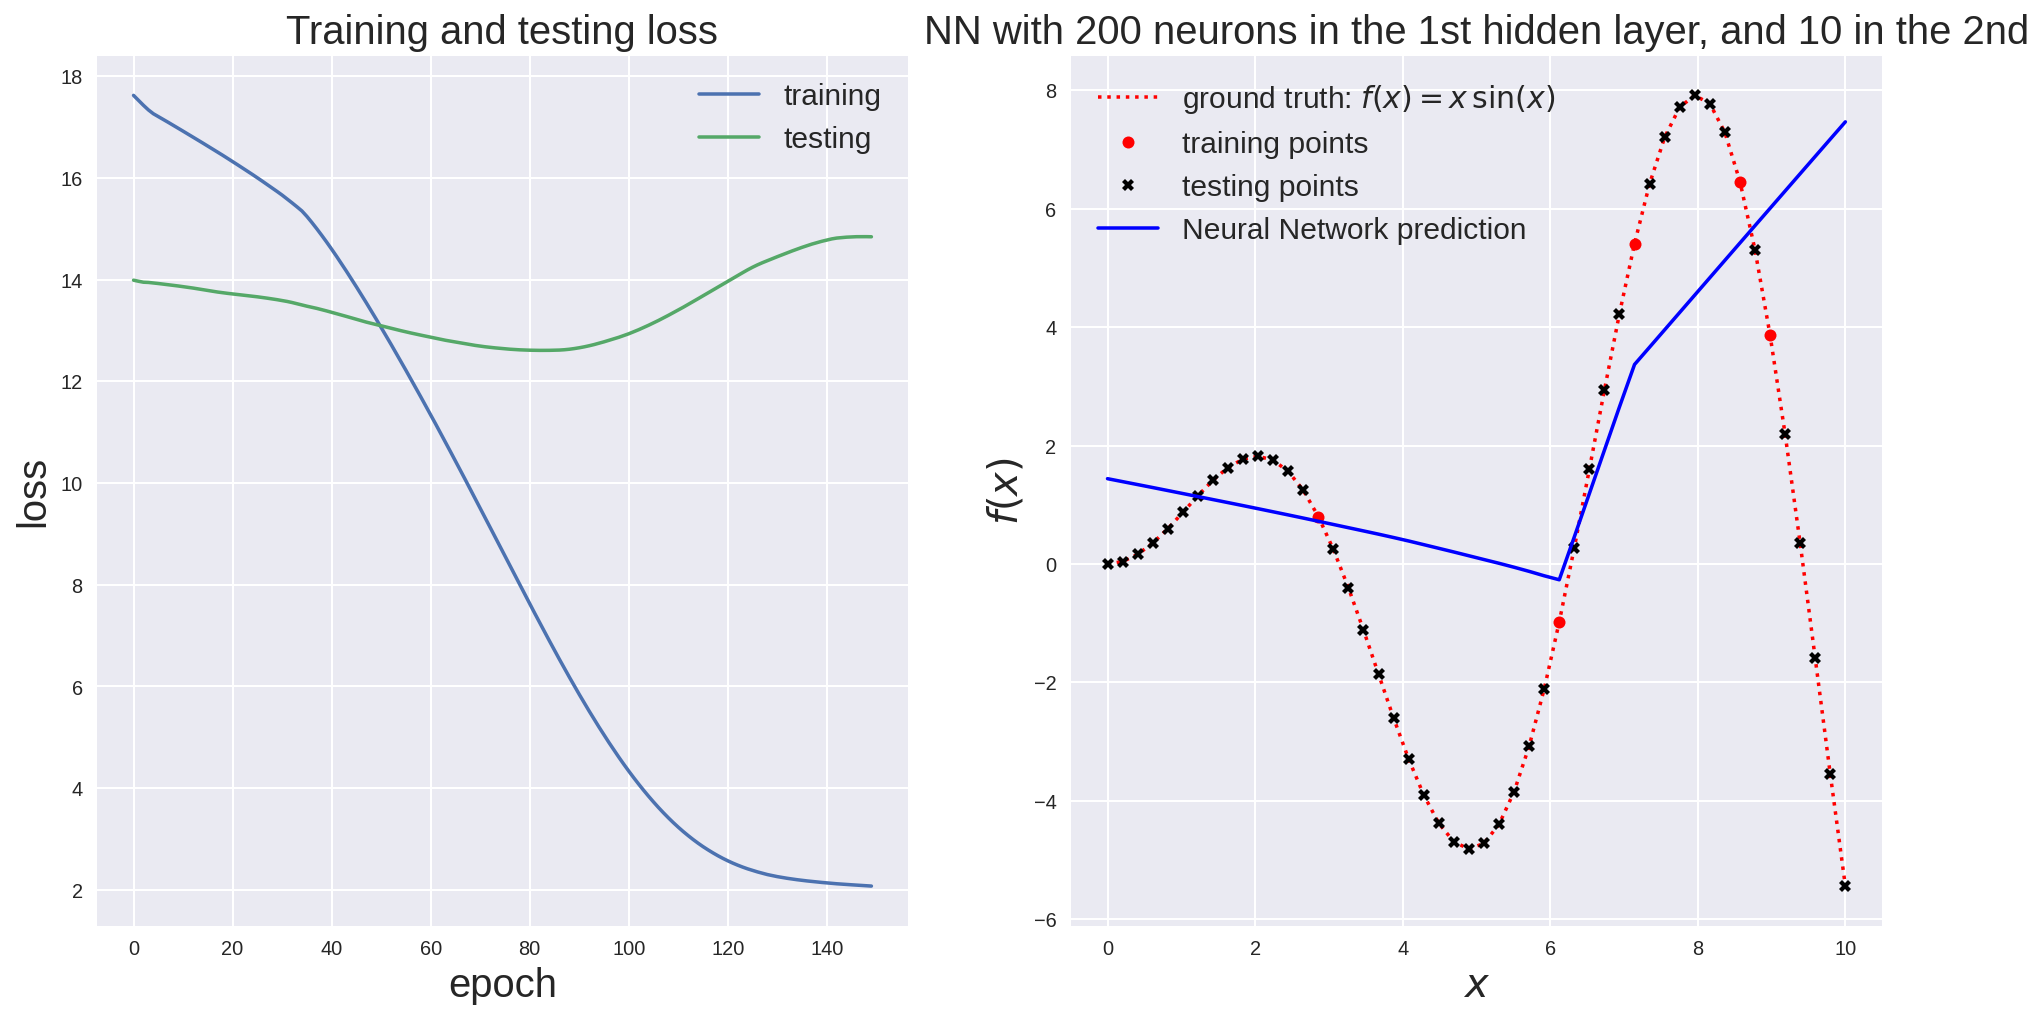

In [16]:
fig_ANN # show figure now.

Not the most amazing model you have ever seen, right?

* Try again but now using 200 neurons for the first hidden layer and 10 for the second hidden layer.
    - spoiler alert: a bit better, but far from amazing...

It's possible to try to find better hyperparameters (and ANNs have many!).

The notes below (not shown in presentation) contain a simple code to do this by "brute force" in a procedure called grid search.

There are some Bonus questions in the Midterm Project where you can use this strategy to find better hyperparameters...

In [17]:
from keras.callbacks import EarlyStopping # a strategy for complexity control
from sklearn.model_selection import GridSearchCV # simple (brute force) approach to find better hyperparameters.
#
# Function to create the ANN model
#(I am writing the function again, in case we want to change some hyperparameters, e.g. use more layers)
def create_ANN(input_dimensions=1,neurons1=10,neurons2=10,neurons3=10,neurons4=10,
                 activation='relu',optimizer='adam'):
    # create model
    model = Sequential()
    model.add(Dense(neurons1, input_dim=input_dimensions, activation=activation)) # first hidden layer
    model.add(Dense(neurons2, activation=activation)) # second hidden layer
    model.add(Dense(neurons3, activation=activation)) # UNCOMMEND If you want a third hidden layer
    model.add(Dense(neurons4, activation=activation)) # UNCOMMENT if you want a fourth hidden layer, etc.
    model.add(Dense(1)) # output layer with just one neuron (we only have one output)
    model.compile(loss='mse', optimizer=optimizer) # choose error metric and optimizer.
    return model
# -----------------------------------------------------------------------------
#
# create model
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.0, patience=30, mode='min')

# define the grid search parameters:
neurons1 = [5,20,200] # number of neurons in hidden layer 1 (it's a vector because we will run the model)
#neurons1 = [5] # number of neurons in hidden layer 1
#neurons2 = [5,10] # number of neurons in hidden layer 2 (if present; uncomment in create_ANN function)
neurons2 = [5] # number of neurons in hidden layer 2 (if present; uncomment in create_ANN function)
neurons3 = [10] # number of neurons in hidden layer 3 (if present; uncomment in create_ANN function)
neurons4 = [10] # number of neurons in hidden layer 4 (if present; uncomment in create_ANN function)
#
batch_size = [len(X_train)] # here considering batch size as large as the training data.
#
epochs = [1000]
#
optimizer = ['adam'] # if we specify the optimizer as a string, then you use the default parameters
#optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
#init_mode = ['uniform', 'lecun_uniform', 'normal', 'orthogonal', 'zero', 'one', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']    
#
param_grid = dict(batch_size=batch_size, epochs=epochs,neurons1=neurons1,neurons2=neurons2,
                  neurons3=neurons3,neurons4=neurons4, # comment this line if you don't want to use layer 3 and 4
                  #init_mode=init_mode, # comment this line if you are not specifying the initialization mode
                  optimizer=optimizer)
NN_model = KerasRegressor(build_fn=create_ANN)
grid = GridSearchCV(estimator=NN_model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train_scaled, y_train, callbacks=[early_stopping],
                       validation_data=(scaler.transform(X_test), y_test))
history = grid_result.best_estimator_.fit(X_train_scaled, y_train,callbacks=[early_stopping],
                                          validation_data=(scaler.transform(X_test), y_test))
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/tmp/ipykernel_12147/1275725502.py:42: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  NN_model = KerasRegressor(build_fn=create_ANN)
2022-03-19 19:40:58.063267: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-19 19:40:58.176515: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-19 19:40:58.177601: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-19 19:40:58.178327: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1900] Ignoring visible gpu device (device: 0, name: GeForce G

2022-03-19 19:40:59.297151: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-19 19:40:59.298644: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-19 19:40:59.299762: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1900] Ignoring visible gpu device (device: 0, name: GeForce GTX 560M, pci bus id: 0000:01:00.0, compute capability: 2.1) with Cuda compute capability 2.1. The minimum required Cuda capability is 3.5.
2022-03-19 19:40:59.300536: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in othe

Epoch 1/1000
1/1 [==============================] - 2s 2s/step - loss: 18.3162 - val_loss: 14.0043
Epoch 2/1000
1/1 [==============================] - 0s 109ms/step - loss: 18.2821 - val_loss: 13.9949
Epoch 3/1000
1/1 [==============================] - 2s 2s/step - loss: 15.8287 - val_loss: 14.5033
Epoch 2/1000
1/1 [==============================] - 0s 75ms/step - loss: 18.2506 - val_loss: 13.9873
Epoch 4/1000
1/1 [==============================] - 0s 96ms/step - loss: 15.7694 - val_loss: 14.4589
Epoch 3/1000
1/1 [==============================] - 1s 1s/step - loss: 19.8741 - val_loss: 14.0461
Epoch 1/1000
1/1 [==============================] - 0s 53ms/step - loss: 15.7110 - val_loss: 14.4176
Epoch 4/1000
1/1 [==============================] - 1s 1s/step - loss: 14.9535 - val_loss: 13.9873
Epoch 2/1000
1/1 [==============================] - 0s 109ms/step - loss: 18.2209 - val_loss: 13.9808
Epoch 5/1000
1/1 [==============================] - 0s 64ms/step - loss: 14.9270 - val_loss: 13.9

1/1 [==============================] - 0s 84ms/step - loss: 15.1822 - val_loss: 14.1118
Epoch 11/1000
1/1 [==============================] - 0s 51ms/step - loss: 19.4565 - val_loss: 13.9866
Epoch 10/1000
1/1 [==============================] - 0s 75ms/step - loss: 19.0568 - val_loss: 13.9393
Epoch 8/1000
1/1 [==============================] - 0s 73ms/step - loss: 14.6078 - val_loss: 14.0369
Epoch 14/1000
1/1 [==============================] - 0s 67ms/step - loss: 18.0192 - val_loss: 13.9535
Epoch 18/1000
1/1 [==============================] - 0s 54ms/step - loss: 17.9061 - val_loss: 13.9254
Epoch 12/1000
1/1 [==============================] - 0s 50ms/step - loss: 19.0303 - val_loss: 13.9323
Epoch 9/1000
1/1 [==============================] - 0s 97ms/step - loss: 19.4179 - val_loss: 13.9713
Epoch 15/1000
1/1 [==============================] - 0s 67ms/step - loss: 19.4160 - val_loss: 13.9815
Epoch 12/1000
1/1 [==============================] - 0s 94ms/step - loss: 15.1497 - val_loss: 14.0

1/1 [==============================] - 0s 62ms/step - loss: 19.1351 - val_loss: 13.9349
Epoch 21/1000
1/1 [==============================] - 0s 60ms/step - loss: 14.3011 - val_loss: 14.1462
Epoch 24/1000
1/1 [==============================] - 0s 62ms/step - loss: 14.5076 - val_loss: 13.9072
Epoch 19/1000
1/1 [==============================] - 0s 87ms/step - loss: 19.0768 - val_loss: 13.9528
Epoch 21/1000
1/1 [==============================] - 0s 63ms/step - loss: 14.9085 - val_loss: 14.0291
Epoch 25/1000
1/1 [==============================] - 0s 52ms/step - loss: 19.1051 - val_loss: 13.9316
Epoch 25/1000
1/1 [==============================] - 0s 52ms/step - loss: 14.2648 - val_loss: 14.1636
Epoch 24/1000
1/1 [==============================] - 0s 56ms/step - loss: 14.4811 - val_loss: 13.9038
Epoch 16/1000
1/1 [==============================] - 0s 69ms/step - loss: 14.8804 - val_loss: 14.0234
Epoch 22/1000
1/1 [==============================] - 0s 48ms/step - loss: 17.8975 - val_loss: 13

1/1 [==============================] - 0s 65ms/step - loss: 18.8442 - val_loss: 13.9090
Epoch 34/1000
1/1 [==============================] - 0s 46ms/step - loss: 14.7201 - val_loss: 13.9990
Epoch 32/1000
1/1 [==============================] - 0s 89ms/step - loss: 17.7948 - val_loss: 13.9168
Epoch 24/1000
1/1 [==============================] - 0s 55ms/step - loss: 14.2235 - val_loss: 13.8720
Epoch 36/1000
1/1 [==============================] - 0s 63ms/step - loss: 17.3808 - val_loss: 13.8475
Epoch 31/1000
1/1 [==============================] - 0s 32ms/step - loss: 17.7787 - val_loss: 13.9143
Epoch 37/1000
1/1 [==============================] - 0s 92ms/step - loss: 18.7764 - val_loss: 13.9359
Epoch 31/1000
1/1 [==============================] - 0s 40ms/step - loss: 17.3513 - val_loss: 13.8430
Epoch 32/1000
1/1 [==============================] - 0s 61ms/step - loss: 14.1927 - val_loss: 13.8682
Epoch 30/1000
1/1 [==============================] - 0s 96ms/step - loss: 14.6945 - val_loss: 13

1/1 [==============================] - 0s 63ms/step - loss: 17.0411 - val_loss: 13.8032
Epoch 40/1000
1/1 [==============================] - 0s 101ms/step - loss: 18.5759 - val_loss: 13.8782
Epoch 45/1000
1/1 [==============================] - 0s 66ms/step - loss: 14.4749 - val_loss: 13.9789
Epoch 42/1000
1/1 [==============================] - 0s 51ms/step - loss: 18.6260 - val_loss: 13.9189
Epoch 42/1000
1/1 [==============================] - 0s 76ms/step - loss: 18.1700 - val_loss: 13.7041
Epoch 36/1000
1/1 [==============================] - 0s 59ms/step - loss: 17.0082 - val_loss: 13.8001
Epoch 46/1000
1/1 [==============================] - 0s 54ms/step - loss: 18.6108 - val_loss: 13.9169
Epoch 43/1000
1/1 [==============================] - 0s 107ms/step - loss: 13.8166 - val_loss: 13.8285
Epoch 47/1000
1/1 [==============================] - 0s 47ms/step - loss: 17.5177 - val_loss: 13.8659
Epoch 37/1000
1/1 [==============================] - 0s 52ms/step - loss: 18.5048 - val_loss: 

Epoch 58/1000
1/1 [==============================] - 0s 55ms/step - loss: 16.5824 - val_loss: 13.7685
Epoch 55/1000
1/1 [==============================] - 0s 50ms/step - loss: 13.3491 - val_loss: 13.7961
Epoch 52/1000
1/1 [==============================] - 0s 65ms/step - loss: 18.4383 - val_loss: 13.8893
Epoch 53/1000
1/1 [==============================] - 0s 77ms/step - loss: 17.2644 - val_loss: 13.8189
Epoch 62/1000
1/1 [==============================] - 0s 97ms/step - loss: 14.1858 - val_loss: 13.9850
Epoch 59/1000
1/1 [==============================] - 0s 49ms/step - loss: 13.3013 - val_loss: 13.7934
Epoch 53/1000
1/1 [==============================] - 0s 87ms/step - loss: 16.5442 - val_loss: 13.7674
Epoch 63/1000
1/1 [==============================] - 0s 51ms/step - loss: 14.1638 - val_loss: 13.9863
Epoch 54/1000
1/1 [==============================] - 0s 64ms/step - loss: 18.2119 - val_loss: 13.8181
Epoch 60/1000
1/1 [==============================] - 0s 52ms/step - loss: 17.2115 

1/1 [==============================] - 0s 88ms/step - loss: 17.1794 - val_loss: 13.9012
Epoch 64/1000
1/1 [==============================] - 0s 80ms/step - loss: 17.9940 - val_loss: 13.7832
Epoch 10/1000
1/1 [==============================] - 0s 52ms/step - loss: 12.7691 - val_loss: 13.7694
Epoch 68/1000
1/1 [==============================] - 0s 87ms/step - loss: 13.9858 - val_loss: 13.9995
Epoch 63/1000
1/1 [==============================] - 0s 57ms/step - loss: 16.1796 - val_loss: 13.7644
Epoch 65/1000
1/1 [==============================] - 0s 56ms/step - loss: 17.9642 - val_loss: 13.7786
Epoch 69/1000
1/1 [==============================] - 0s 58ms/step - loss: 12.7094 - val_loss: 13.7675
Epoch 65/1000
1/1 [==============================] - 0s 92ms/step - loss: 18.2544 - val_loss: 13.8466
Epoch 63/1000
1/1 [==============================] - 0s 46ms/step - loss: 16.9372 - val_loss: 13.7579
Epoch 55/1000
1/1 [==============================] - 0s 62ms/step - loss: 16.1363 - val_loss: 13

1/1 [==============================] - 0s 77ms/step - loss: 18.0971 - val_loss: 13.8167
Epoch 71/1000
1/1 [==============================] - 0s 58ms/step - loss: 16.7152 - val_loss: 13.7169
Epoch 79/1000
1/1 [==============================] - 0s 83ms/step - loss: 13.7588 - val_loss: 14.0253
Epoch 18/1000
1/1 [==============================] - 0s 63ms/step - loss: 11.9613 - val_loss: 13.7472
Epoch 75/1000
1/1 [==============================] - 0s 65ms/step - loss: 16.9791 - val_loss: 14.2951
Epoch 62/1000
1/1 [==============================] - 0s 47ms/step - loss: 16.6743 - val_loss: 13.7095
Epoch 78/1000
1/1 [==============================] - 0s 67ms/step - loss: 18.0764 - val_loss: 13.8128
Epoch 74/1000
1/1 [==============================] - 0s 47ms/step - loss: 17.6462 - val_loss: 13.7020
Epoch 76/1000
1/1 [==============================] - 0s 57ms/step - loss: 18.0555 - val_loss: 13.8089
Epoch 73/1000
1/1 [==============================] - 0s 89ms/step - loss: 16.1179 - val_loss: 13

1/1 [==============================] - 0s 57ms/step - loss: 17.8252 - val_loss: 13.7713
Epoch 83/1000
1/1 [==============================] - 0s 44ms/step - loss: 14.2281 - val_loss: 13.6520
Epoch 31/1000
1/1 [==============================] - 0s 77ms/step - loss: 17.2476 - val_loss: 13.5652
Epoch 90/1000
1/1 [==============================] - 0s 49ms/step - loss: 17.7998 - val_loss: 13.7666
Epoch 84/1000
1/1 [==============================] - 0s 83ms/step - loss: 16.2025 - val_loss: 13.6246
Epoch 86/1000
1/1 [==============================] - 0s 91ms/step - loss: 10.8013 - val_loss: 13.7423
Epoch 88/1000
1/1 [==============================] - 0s 72ms/step - loss: 14.0359 - val_loss: 13.6144
Epoch 32/1000
1/1 [==============================] - 0s 68ms/step - loss: 17.2075 - val_loss: 13.5557
Epoch 91/1000
1/1 [==============================] - 0s 49ms/step - loss: 17.7739 - val_loss: 13.7617
Epoch 85/1000
1/1 [==============================] - 0s 42ms/step - loss: 10.6945 - val_loss: 13

1/1 [==============================] - 0s 65ms/step - loss: 9.0541 - val_loss: 13.7943
Epoch 102/1000
1/1 [==============================] - 0s 46ms/step - loss: 16.5726 - val_loss: 13.4082
Epoch 105/1000
1/1 [==============================] - 0s 57ms/step - loss: 17.3171 - val_loss: 13.6782
Epoch 100/1000
1/1 [==============================] - 0s 31ms/step - loss: 16.5210 - val_loss: 13.3973
Epoch 106/1000
1/1 [==============================] - 0s 54ms/step - loss: 8.9065 - val_loss: 13.7998
Epoch 103/1000
1/1 [==============================] - 0s 67ms/step - loss: 14.2111 - val_loss: 13.5872
Epoch 104/1000
1/1 [==============================] - 0s 61ms/step - loss: 10.0654 - val_loss: 12.9671
Epoch 107/1000
1/1 [==============================] - 0s 49ms/step - loss: 15.2519 - val_loss: 13.4585
Epoch 104/1000
1/1 [==============================] - 0s 50ms/step - loss: 14.1373 - val_loss: 13.5755
Epoch 105/1000
1/1 [==============================] - 0s 93ms/step - loss: 17.2809 - val_l

1/1 [==============================] - 0s 45ms/step - loss: 14.1434 - val_loss: 13.2915
Epoch 118/1000
1/1 [==============================] - 0s 91ms/step - loss: 16.7711 - val_loss: 13.5756
Epoch 113/1000
1/1 [==============================] - 0s 58ms/step - loss: 5.4875 - val_loss: 13.8381
Epoch 120/1000
1/1 [==============================] - 0s 62ms/step - loss: 12.7717 - val_loss: 13.2982
Epoch 116/1000
1/1 [==============================] - 0s 50ms/step - loss: 14.0469 - val_loss: 13.2759
Epoch 119/1000
1/1 [==============================] - 0s 54ms/step - loss: 16.7210 - val_loss: 13.5660
Epoch 121/1000
1/1 [==============================] - 0s 50ms/step - loss: 5.1605 - val_loss: 13.9822
Epoch 63/1000
1/1 [==============================] - 0s 36ms/step - loss: 13.9484 - val_loss: 13.2591
Epoch 120/1000
1/1 [==============================] - 0s 59ms/step - loss: 12.6653 - val_loss: 13.2746
Epoch 117/1000
1/1 [==============================] - 0s 36ms/step - loss: 15.5544 - val_lo

Epoch 131/1000
1/1 [==============================] - 0s 45ms/step - loss: 12.3465 - val_loss: 13.0202
Epoch 133/1000
1/1 [==============================] - 0s 46ms/step - loss: 14.4535 - val_loss: 13.1071
Epoch 136/1000
1/1 [==============================] - 0s 35ms/step - loss: 10.8554 - val_loss: 12.9228
Epoch 132/1000
1/1 [==============================] - 0s 82ms/step - loss: 15.7743 - val_loss: 13.3840
Epoch 129/1000
1/1 [==============================] - 0s 40ms/step - loss: 14.3644 - val_loss: 13.1036
Epoch 137/1000
1/1 [==============================] - 0s 35ms/step - loss: 10.7195 - val_loss: 12.9014
Epoch 133/1000
1/1 [==============================] - 0s 54ms/step - loss: 12.2020 - val_loss: 13.0069
Epoch 134/1000
1/1 [==============================] - 0s 37ms/step - loss: 1.5534 - val_loss: 18.0154
Epoch 78/1000
1/1 [==============================] - 0s 46ms/step - loss: 15.6956 - val_loss: 13.3687
Epoch 130/1000
1/1 [==============================] - 0s 41ms/step - loss: 

1/1 [==============================] - 0s 50ms/step - loss: 9.3839 - val_loss: 12.9251
Epoch 152/1000
1/1 [==============================] - 0s 39ms/step - loss: 7.8517 - val_loss: 12.6996
Epoch 152/1000
1/1 [==============================] - 0s 45ms/step - loss: 12.2746 - val_loss: 13.1075
Epoch 157/1000
1/1 [==============================] - 0s 46ms/step - loss: 13.8658 - val_loss: 13.0495
Epoch 148/1000
1/1 [==============================] - 0s 37ms/step - loss: 9.2191 - val_loss: 12.9342
Epoch 153/1000
1/1 [==============================] - 0s 36ms/step - loss: 7.6903 - val_loss: 12.7000
Epoch 153/1000
1/1 [==============================] - 0s 38ms/step - loss: 12.1543 - val_loss: 13.1151
Epoch 158/1000
1/1 [==============================] - 0s 32ms/step - loss: 13.7404 - val_loss: 13.0308
Epoch 149/1000
1/1 [==============================] - 0s 37ms/step - loss: 9.0537 - val_loss: 12.9448
Epoch 154/1000
1/1 [==============================] - 0s 42ms/step - loss: 7.5279 - val_loss:

1/1 [==============================] - 0s 59ms/step - loss: 5.8256 - val_loss: 13.5895
Epoch 169/1000
1/1 [==============================] - 0s 57ms/step - loss: 9.3257 - val_loss: 13.5755
Epoch 179/1000
1/1 [==============================] - 0s 50ms/step - loss: 4.5009 - val_loss: 13.2028
Epoch 173/1000
1/1 [==============================] - 0s 45ms/step - loss: 10.5834 - val_loss: 12.6063
Epoch 170/1000
1/1 [==============================] - 0s 41ms/step - loss: 9.1794 - val_loss: 13.6120
Epoch 180/1000
1/1 [==============================] - 0s 62ms/step - loss: 5.6741 - val_loss: 13.6485
Epoch 175/1000
1/1 [==============================] - 0s 40ms/step - loss: 10.4131 - val_loss: 12.5859
Epoch 171/1000
1/1 [==============================] - 0s 46ms/step - loss: 4.2107 - val_loss: 13.3178
Epoch 175/1000
1/1 [==============================] - 0s 40ms/step - loss: 5.5243 - val_loss: 13.7103
Epoch 176/1000
1/1 [==============================] - 0s 49ms/step - loss: 10.2409 - val_loss: 

1/1 [==============================] - 0s 28ms/step - loss: 17.3690 - val_loss: 13.9653
Epoch 6/1000
1/1 [==============================] - 0s 29ms/step - loss: 17.3494 - val_loss: 13.9631
Epoch 7/1000
1/1 [==============================] - 0s 24ms/step - loss: 17.3296 - val_loss: 13.9610
Epoch 8/1000
1/1 [==============================] - 0s 29ms/step - loss: 17.3095 - val_loss: 13.9588
Epoch 9/1000
1/1 [==============================] - 0s 27ms/step - loss: 17.2893 - val_loss: 13.9566
Epoch 10/1000
1/1 [==============================] - 0s 24ms/step - loss: 17.2689 - val_loss: 13.9544
Epoch 11/1000
1/1 [==============================] - 0s 27ms/step - loss: 17.2482 - val_loss: 13.9521
Epoch 12/1000
1/1 [==============================] - 0s 30ms/step - loss: 17.2273 - val_loss: 13.9498
Epoch 13/1000
1/1 [==============================] - 0s 28ms/step - loss: 17.2062 - val_loss: 13.9474
Epoch 14/1000
1/1 [==============================] - 0s 34ms/step - loss: 17.1849 - val_loss: 13.945

1/1 [==============================] - 0s 28ms/step - loss: 14.4606 - val_loss: 13.9205
Epoch 86/1000
1/1 [==============================] - 0s 28ms/step - loss: 14.3951 - val_loss: 13.9208
Epoch 87/1000
1/1 [==============================] - 0s 27ms/step - loss: 14.3282 - val_loss: 13.9201
Epoch 88/1000
1/1 [==============================] - 0s 24ms/step - loss: 14.2602 - val_loss: 13.9186
Epoch 89/1000
1/1 [==============================] - 0s 26ms/step - loss: 14.1914 - val_loss: 13.9166
Epoch 90/1000
1/1 [==============================] - 0s 28ms/step - loss: 14.1214 - val_loss: 13.9138
Epoch 1/1000
1/1 [==============================] - 1s 504ms/step - loss: 16.8783 - val_loss: 13.8898
Epoch 2/1000
1/1 [==============================] - 0s 29ms/step - loss: 16.8111 - val_loss: 13.8778
Epoch 3/1000
1/1 [==============================] - 0s 28ms/step - loss: 16.7429 - val_loss: 13.8669
Epoch 4/1000
1/1 [==============================] - 0s 29ms/step - loss: 16.6756 - val_loss: 13.85

1/1 [==============================] - 0s 27ms/step - loss: 9.2847 - val_loss: 13.1642
Epoch 76/1000
1/1 [==============================] - 0s 29ms/step - loss: 9.1361 - val_loss: 13.1533
Epoch 77/1000
1/1 [==============================] - 0s 25ms/step - loss: 8.9865 - val_loss: 13.1422
Epoch 78/1000
1/1 [==============================] - 0s 25ms/step - loss: 8.8360 - val_loss: 13.1314
Epoch 79/1000
1/1 [==============================] - 0s 28ms/step - loss: 8.6857 - val_loss: 13.1216
Epoch 80/1000
1/1 [==============================] - 0s 28ms/step - loss: 8.5354 - val_loss: 13.1131
Epoch 81/1000
1/1 [==============================] - 0s 29ms/step - loss: 8.3845 - val_loss: 13.1059
Epoch 82/1000
1/1 [==============================] - 0s 25ms/step - loss: 8.2332 - val_loss: 13.1003
Epoch 83/1000
1/1 [==============================] - 0s 28ms/step - loss: 8.0817 - val_loss: 13.0964
Epoch 84/1000
1/1 [==============================] - 0s 28ms/step - loss: 7.9302 - val_loss: 13.0937
Epoc

In [18]:
fig_ANN, (ax1_ANN, ax2_ANN) = plt.subplots(1,2)
# Create a plot for the loss history
ax1_ANN.plot(history.history['loss']) # plot training loss
ax1_ANN.plot(history.history['val_loss']) # plot testing loss
ax1_ANN.set_title('Training and testing loss', fontsize=20)
ax1_ANN.set_ylabel('loss', fontsize=20)
ax1_ANN.set_xlabel('epoch', fontsize=20)
ax1_ANN.legend(['training', 'testing'], loc='upper right', fontsize=15)

# Create a plot for the ANN prediction
ax2_ANN.plot(x_data, f(x_data), 'r:', label=u'ground truth: $f(x) = x\,\sin(x)$') # show ground truth function
ax2_ANN.plot(x_train, y_train, 'ro', markersize=6, label="training points") # show training data
ax2_ANN.plot(x_test, y_test, 'kX', markersize=6, label="testing points") # show testing data

y_pred = history.model.predict(X_data_scaled) # predict all data points with ANN

ax2_ANN.plot(x_data, y_pred, 'b-', label="Neural Network prediction") # plot prediction
ax2_ANN.set_title(r'NN with '+str(neurons1)+' neurons in the 1st hidden layer, and '+str(neurons2)+' in the 2nd',
                 fontsize=20)
ax2_ANN.set_xlabel('$x$', fontsize=20)
ax2_ANN.set_ylabel('$f(x)$', fontsize=20)
ax2_ANN.legend(loc='upper left', fontsize=15)

# Create figure with specified size
fig_ANN.set_size_inches(16, 8)
plt.close(fig_ANN) # do not plot the figure now. We will show it in the next cell

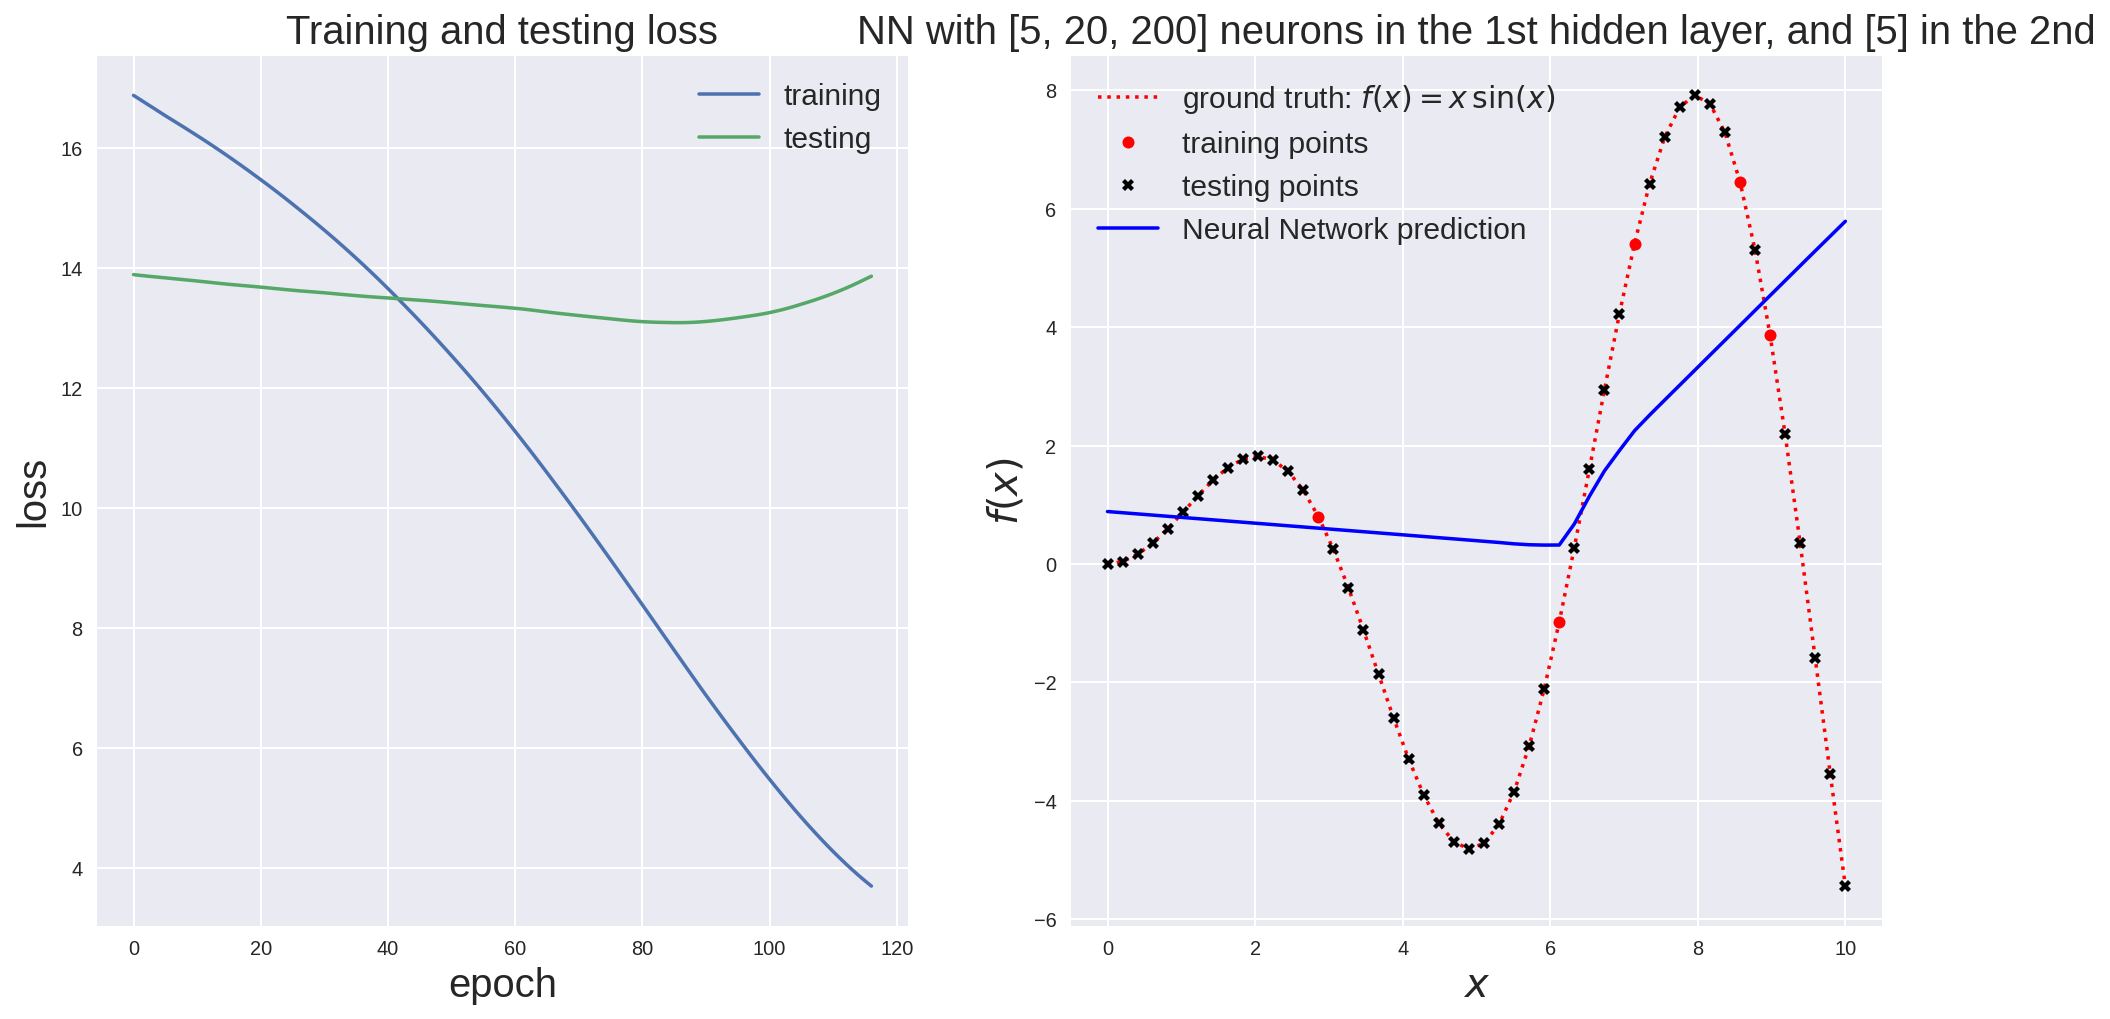

In [19]:
fig_ANN # show figure now.

This neural network approximation is also not brilliant... Were you expecting this?

# <font color='red'>HOMEWORK</font>

Redo the neural network regression but now for the noisy dataset (use the same network we used for the noiseless dataset).

In [20]:
# HOMEWORK.

# until here.

### Solution for Exercise 1

```python
# We start by importing the polynomial predictor from scikit-learn
from sklearn.preprocessing import PolynomialFeatures # For Polynomial fit
from sklearn.linear_model import LinearRegression # For Least Squares
from sklearn.pipeline import make_pipeline # to link different objects

degree = 4 # degree of polynomial we want to fit
poly_model = make_pipeline(PolynomialFeatures(degree),LinearRegression())
poly_model.fit(X_train,y_train) # fit the polynomial to our 5 points in X_train which is a 2D array  
y_poly_pred = poly_model.predict(X_test) # prediction of our polynomial

from sklearn.metrics import mean_squared_error, r2_score # Import error metrics
# Compute MSE and R2 for the GP model
gp_mse_value = mean_squared_error(y_test, y_pred)
gp_r2_value = r2_score(y_test, y_pred)
print('MSE for GPR = ', gp_mse_value)
print('R2 score for GPR = ', gp_r2_value)

# Compute MSE and R2 for the polynomial model
poly_mse_value = mean_squared_error(y_test, y_poly_pred)
poly_r2_value = r2_score(y_test, y_poly_pred)
print('MSE for polynomial = ', poly_mse_value)
print('R2 score for polynomial = ', poly_r2_value)
```

### Solution to Exercise 2

``` python
degree = 4 # degree of polynomial we want to fit
poly_model = make_pipeline(PolynomialFeatures(degree),LinearRegression())
poly_model.fit(X_train,y_noisy_train) # fit the polynomial to our 5 points in X_train which is a 2D array
y_poly_noisy_pred = poly_model.predict(X_test) # prediction of our polynomial

# Compute MSE and R2 for the GP model
# NOTE: here we will compare with the noiseless function (in practice we don't have this information!).
gp_mse_value = mean_squared_error(y_test, y_noisy_pred)
gp_r2_value = r2_score(y_test, y_noisy_pred)
print('MSE for GPR = ', gp_mse_value)
print('R2 score for GPR = ', gp_r2_value)

# Compute MSE and R2 for the polynomial model
poly_mse_value = mean_squared_error(y_test, y_poly_noisy_pred)
poly_r2_value = r2_score(y_test, y_poly_noisy_pred)
print('MSE for polynomial = ', poly_mse_value)
print('R2 score for polynomial = ', poly_r2_value)
```

### Solution to Homework of this Lecture
``` python
# Function to create the ANN model (a feedforward architecture with 2 hidden layers)
def create_ANN(input_dimensions=1, # number of input variables
               neurons1=3, # number of neurons in first hidden layer
               neurons2=2, # number of neurons in second hidden layer
               activation='relu', # activation function
               optimizer='adam'): # optimization algorithm to compute the weights and biases
    # create model
    model = Sequential() # Feedforward architecture
    model.add(Dense(neurons1, input_dim=input_dimensions, activation=activation)) # first hidden layer
    model.add(Dense(neurons2, activation=activation)) # second hidden layer
    model.add(Dense(1)) # output layer with just one neuron because we have only one output (1D problem!)
    model.compile(loss='mse', # error metric to measure our NLL (loss)
                  optimizer=optimizer)
    return model
# -----------------------------------------------------------------------------
#
# Standardizing your dataset is usually a good practice and can be important for ANNs:
scaler = StandardScaler().fit(X_train) # Check scikit-learn to see what this does!
#
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)
X_data_scaled=scaler.transform(X_data)
#

# Now create your first ANN model!
neurons1=200 # number of neurons for the first hidden layer
neurons2=10 # number of neurons for the second hidden layer
batch_size = len(X_train) # considering the entire dataset for updating the weights and biases in each epoch
ANN_model = KerasRegressor(build_fn=create_ANN, neurons1=neurons1, neurons2=neurons2,
                           batch_size=batch_size, epochs=150, optimizer='adam',
                           validation_data=(scaler.transform(X_test), y_noisy_test))

# Now let's train the model on our (scaled) dataset!
history = ANN_model.fit(X_train_scaled, y_noisy_train)

# Finally, plot the loss history and the predicted function.
fig_ANN, (ax1_ANN, ax2_ANN) = plt.subplots(1,2)
# Create a plot for the loss history
ax1_ANN.plot(history.history['loss']) # plot training loss
ax1_ANN.plot(history.history['val_loss']) # plot testing loss
ax1_ANN.set_title('Training and testing loss', fontsize=20)
ax1_ANN.set_ylabel('loss', fontsize=20)
ax1_ANN.set_xlabel('epoch', fontsize=20)
ax1_ANN.legend(['training', 'testing'], loc='upper right', fontsize=15)

# Create a plot for the ANN prediction
ax2_ANN.plot(x_data, f(x_data), 'r:', label=u'ground truth: $f(x) = x\,\sin(x)$') # show ground truth function
ax2_ANN.errorbar(x_train, y_noisy_train, noise_train, fmt='ro', markersize=6, label=u'training points inc. uncertainty')
ax2_ANN.errorbar(x_test, y_noisy_test, noise_test, fmt='kX', markersize=6, label=u'testing points inc. uncertainty')

y_pred = history.model.predict(X_data_scaled) # predict all data points with ANN

ax2_ANN.plot(x_data, y_pred, 'b-', label="Neural Network prediction") # plot prediction
ax2_ANN.set_title(r'NN with '+str(neurons1)+' neurons in the 1st hidden layer, and '+str(neurons2)+' in the 2nd',
                 fontsize=20)
ax2_ANN.set_xlabel('$x$', fontsize=20)
ax2_ANN.set_ylabel('$f(x)$', fontsize=20)
ax2_ANN.legend(loc='upper left', fontsize=15)

# Create figure with specified size
fig_ANN.set_size_inches(16, 8)
```

### You will explore these and other things in Part 1 of the Midterm Project...

Have fun!